In [1]:
%matplotlib inline

#from pixie4e import * # import our python module generated by kaitai struct
import matplotlib.pyplot as plt # plotting modules
import random
#import numpy as np # numpy provides useful array manipulations like average, max, etc.


import struct
import numpy
import awkward

In [ ]:
fileheader = struct.Struct("<hhhhhhhhhhhhhxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
channelheader = struct.Struct("<hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh")

channelheaders = []
tracedata = []
tracecounts = []
with open("C:/Users/canto/Repositories/xia.git/data/LaBr_Na22coinc_attn8_500fast_0148/LaBr_Na22coinc_attn8_500fast_0148.b00", "rb") as file:
    blk_size, mod_num, run_format, chan_head_len, coinc_pat, coinc_win, max_comb_event_len, board_version, event_length_0, event_length_1, event_length_2, event_length_3, serial_number = fileheader.unpack(file.read(fileheader.size))
    while True:
        headerdata = file.read(channelheader.size)
        if len(headerdata) != channelheader.size:
            break
        channelheaders.append(channelheader.unpack(headerdata))
        num_trace_blks = channelheaders[-1][2]
        tracedata.append(numpy.frombuffer(file.read((num_trace_blks * blk_size) * 2), dtype=numpy.int16))
        tracecounts.append(num_trace_blks * blk_size)

channelheaders = numpy.array(channelheaders, dtype=[("evt_pattern", numpy.int16), ("evt_info", numpy.int16), ("num_trace_blks", numpy.int16), ("num_trace_blks_prev", numpy.int16), ("trig_time_lo", numpy.int16), ("trig_time_mi", numpy.int16), ("trig_time_hi", numpy.int16), ("trig_time_x", numpy.int16), ("energy", numpy.int16), ("chan_no", numpy.int16), ("user_psa_value", numpy.int16), ("xia_psa_value", numpy.int16), ("extended_psa_values0", numpy.int16), ("extended_psa_values1", numpy.int16), ("extended_psa_values2", numpy.int16), ("extended_psa_values3", numpy.int16), ("reserved0", numpy.int16), ("reserved1", numpy.int16), ("reserved2", numpy.int16), ("reserved3", numpy.int16), ("reserved4", numpy.int16), ("reserved5", numpy.int16), ("reserved6", numpy.int16), ("reserved7", numpy.int16), ("reserved8", numpy.int16), ("reserved9", numpy.int16), ("reserved10", numpy.int16), ("reserved11", numpy.int16), ("reserved12", numpy.int16), ("reserved13", numpy.int16), ("reserved14", numpy.int16), ("reserved15", numpy.int16)])

channels = awkward.Table.fromrec(channelheaders)
channels["traces"] = awkward.JaggedArray.fromcounts(tracecounts, numpy.concatenate(tracedata))

In [7]:
channels.columns

['evt_pattern',
 'evt_info',
 'num_trace_blks',
 'num_trace_blks_prev',
 'trig_time_lo',
 'trig_time_mi',
 'trig_time_hi',
 'trig_time_x',
 'energy',
 'chan_no',
 'user_psa_value',
 'xia_psa_value',
 'extended_psa_values0',
 'extended_psa_values1',
 'extended_psa_values2',
 'extended_psa_values3',
 'reserved0',
 'reserved1',
 'reserved2',
 'reserved3',
 'reserved4',
 'reserved5',
 'reserved6',
 'reserved7',
 'reserved8',
 'reserved9',
 'reserved10',
 'reserved11',
 'reserved12',
 'reserved13',
 'reserved14',
 'reserved15',
 'traces']

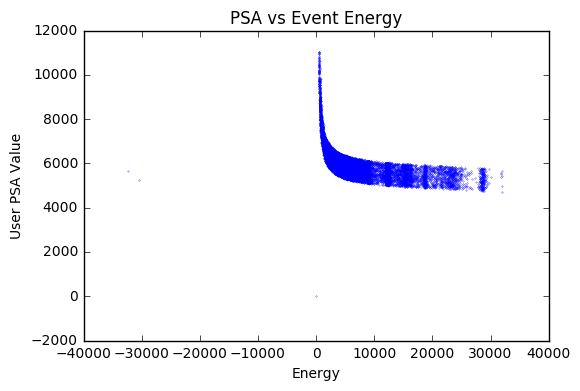

In [21]:
#plt.figure(figsize=(15,10))
plt.scatter(channels["energy"], channels["xia_psa_value"], marker='o', s=0.05, color='b')
plt.xlabel('Energy')
plt.ylabel('User PSA Value')
plt.title('PSA vs Event Energy')
plt.show()


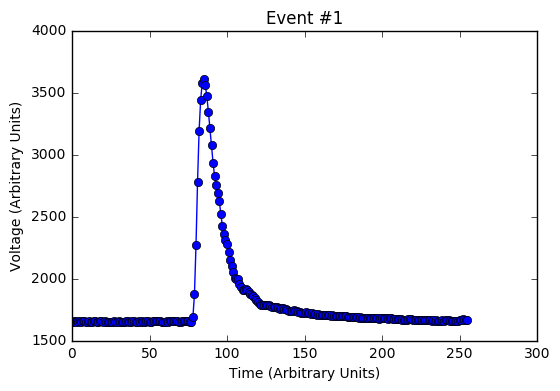

In [45]:
# Plot a pulse from the file
event_number = 1

trace = channels["traces"][event_number]
plt.plot(trace, '-o')

plt.title("Event #" + str(event_number))
plt.xlabel("Time (Arbitrary Units)")
plt.ylabel("Voltage (Arbitrary Units)")

In [42]:
def get_baseline(trace_data):
    start_idx = 4
    final_idx = start_idx + 8
    print (numpy.size(trace_data))
    print (type(trace_data))
    
    base = numpy.average(trace_data[start_idx:final_idx])
    
    return base
    
# not used yet; model for findlevel?
# find 10% level before max, searching back from maximum
# findlevel/q/R=(V_maxloc,0) trace, (base+ampl*RTlow)
# lev10 = V_levelX    //in x units
def find_nearest(array, value):
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    
    return idx

def process_pulse(pulse):
    # get a baseline
    base = get_baseline(pulse)
    #print(base)

    # find the amplitude
    ampl = numpy.max(pulse) - base
    #print(ampl)
    
    # find the integral
    integral = numpy.sum(pulse - base)

    # calculate Q1Sum
    # need to be able to find index associated with 10% max amplitude
    # for a good Q1start, Q0start
    Q1start = numpy.argmax(pulse)
    start_idx = Q1start + SoQ1
    final_idx = Q1start + SoQ1 + LoQ1

    Q1Sum = numpy.sum(pulse[start_idx:final_idx] - base)
    #print(Q1Sum)

    # calculate Q0Sum
    Q1start = numpy.argmax(pulse)
    start_idx = Q1start + SoQ0
    final_idx = Q1start + SoQ0 + LoQ0

    Q0Sum = numpy.sum(pulse[start_idx:final_idx] - base)
    
    return ampl, integral

In [50]:
# these are indices, currently unused
SoQ0 = 10
LoQ0 = 20
SoQ1 = 100
LoQ1 = 5

# this works nicely:
channels["traces"].max()

#print(numpy.size(channels["traces"][1:2]))
#print(type(channels["traces"]))

# this has trouble with the numpy.average call in get_baseline:
base_arr = channels["traces"].apply(get_baseline)

#ampl_arr, integral_arr = process_pulse(channels["traces"])

# get the amplitudes and integrals for each event
#ampl_arr = np.zeros(np.size(pixie_data.events[:-1]))
#integral_arr = np.zeros(np.size(pixie_data.events[:-1]))
#for idx, event in enumerate(pixie_data.events[:-1]):
#    pulse = event.data
#    
#    ampl, integral = process_pulse(pulse)
#    
#    ampl_arr[idx] = ampl
#    integral_arr[idx] = integral

15442
<class 'awkward.array.jagged.JaggedArray'>


AttributeError: 'float' object has no attribute 'dtype'

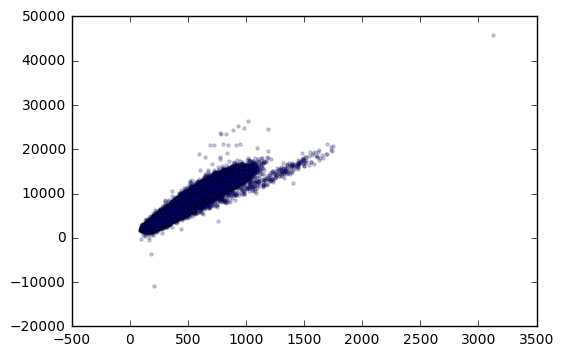

In [8]:
plt.scatter(ampl_arr, integral_arr, marker='.', alpha=0.2)